# Language Classification Hackathon


Companies are always looking for ways to better create products that are better integrated to people's lives. This integration is even more important in the technology sector. Because of technologies such internet-of-things (IoT), communication between man/womxm and machine is now possible. Before a dialog can between between two entities there must be a common medium of communication and language is that medium. South Africa a multi-cultural nation with 11 official languages, and if we are going to create products with widespread appeal they need to be adapted to the lives of the users and language is an important part of that.


In this challenge we're going to build a model for language identication

# Importing libraries

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# set plot style
sns.set(style = 'whitegrid')

# Loading data

In [18]:
# Loading training data set
train_df = pd.read_csv(r"C:\Users\kholo\Downloads\train_set.csv\train_set.csv")
# loading testing data set
test_df = pd.read_csv(r"C:\Users\kholo\Downloads\test_set.csv")                      

# Data overview

In [19]:
train_df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [20]:
test_df.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [21]:
np.shape(train_df)

(33000, 2)

Our training set has 33000 observations

In [22]:
list(train_df['lang_id'].unique())

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

We have 11 different languages. Now we're going to check how they are distributed

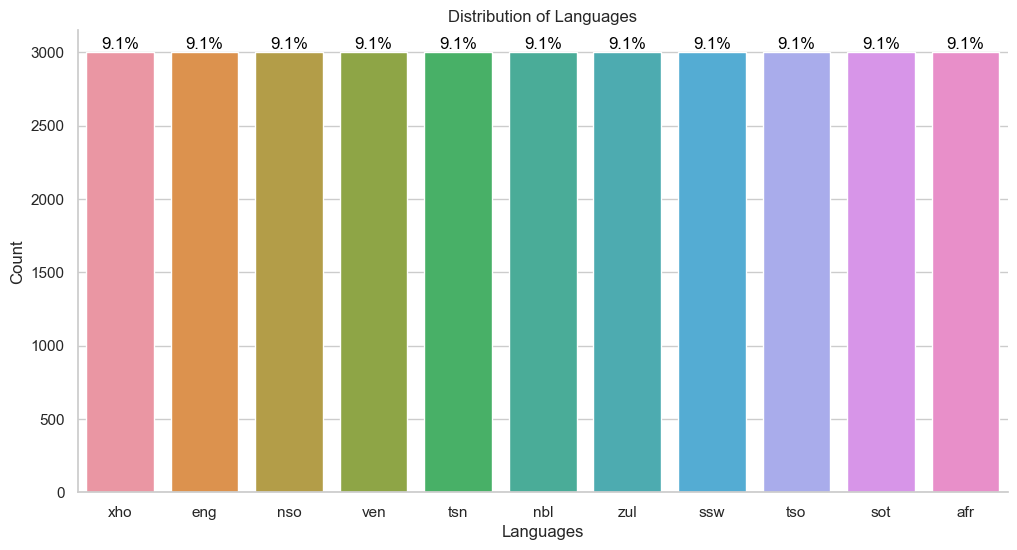

In [23]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='lang_id', data=train_df)
plt.title('Distribution of Languages')
plt.xlabel('Languages')
plt.ylabel('Count')

total = len(train_df['lang_id'])

for p in ax.patches:
    percentage = f'{(p.get_height() / total) * 100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')

sns.despine()

plt.show()


The observations are balanced throughout all the classes

# Most common words in each language


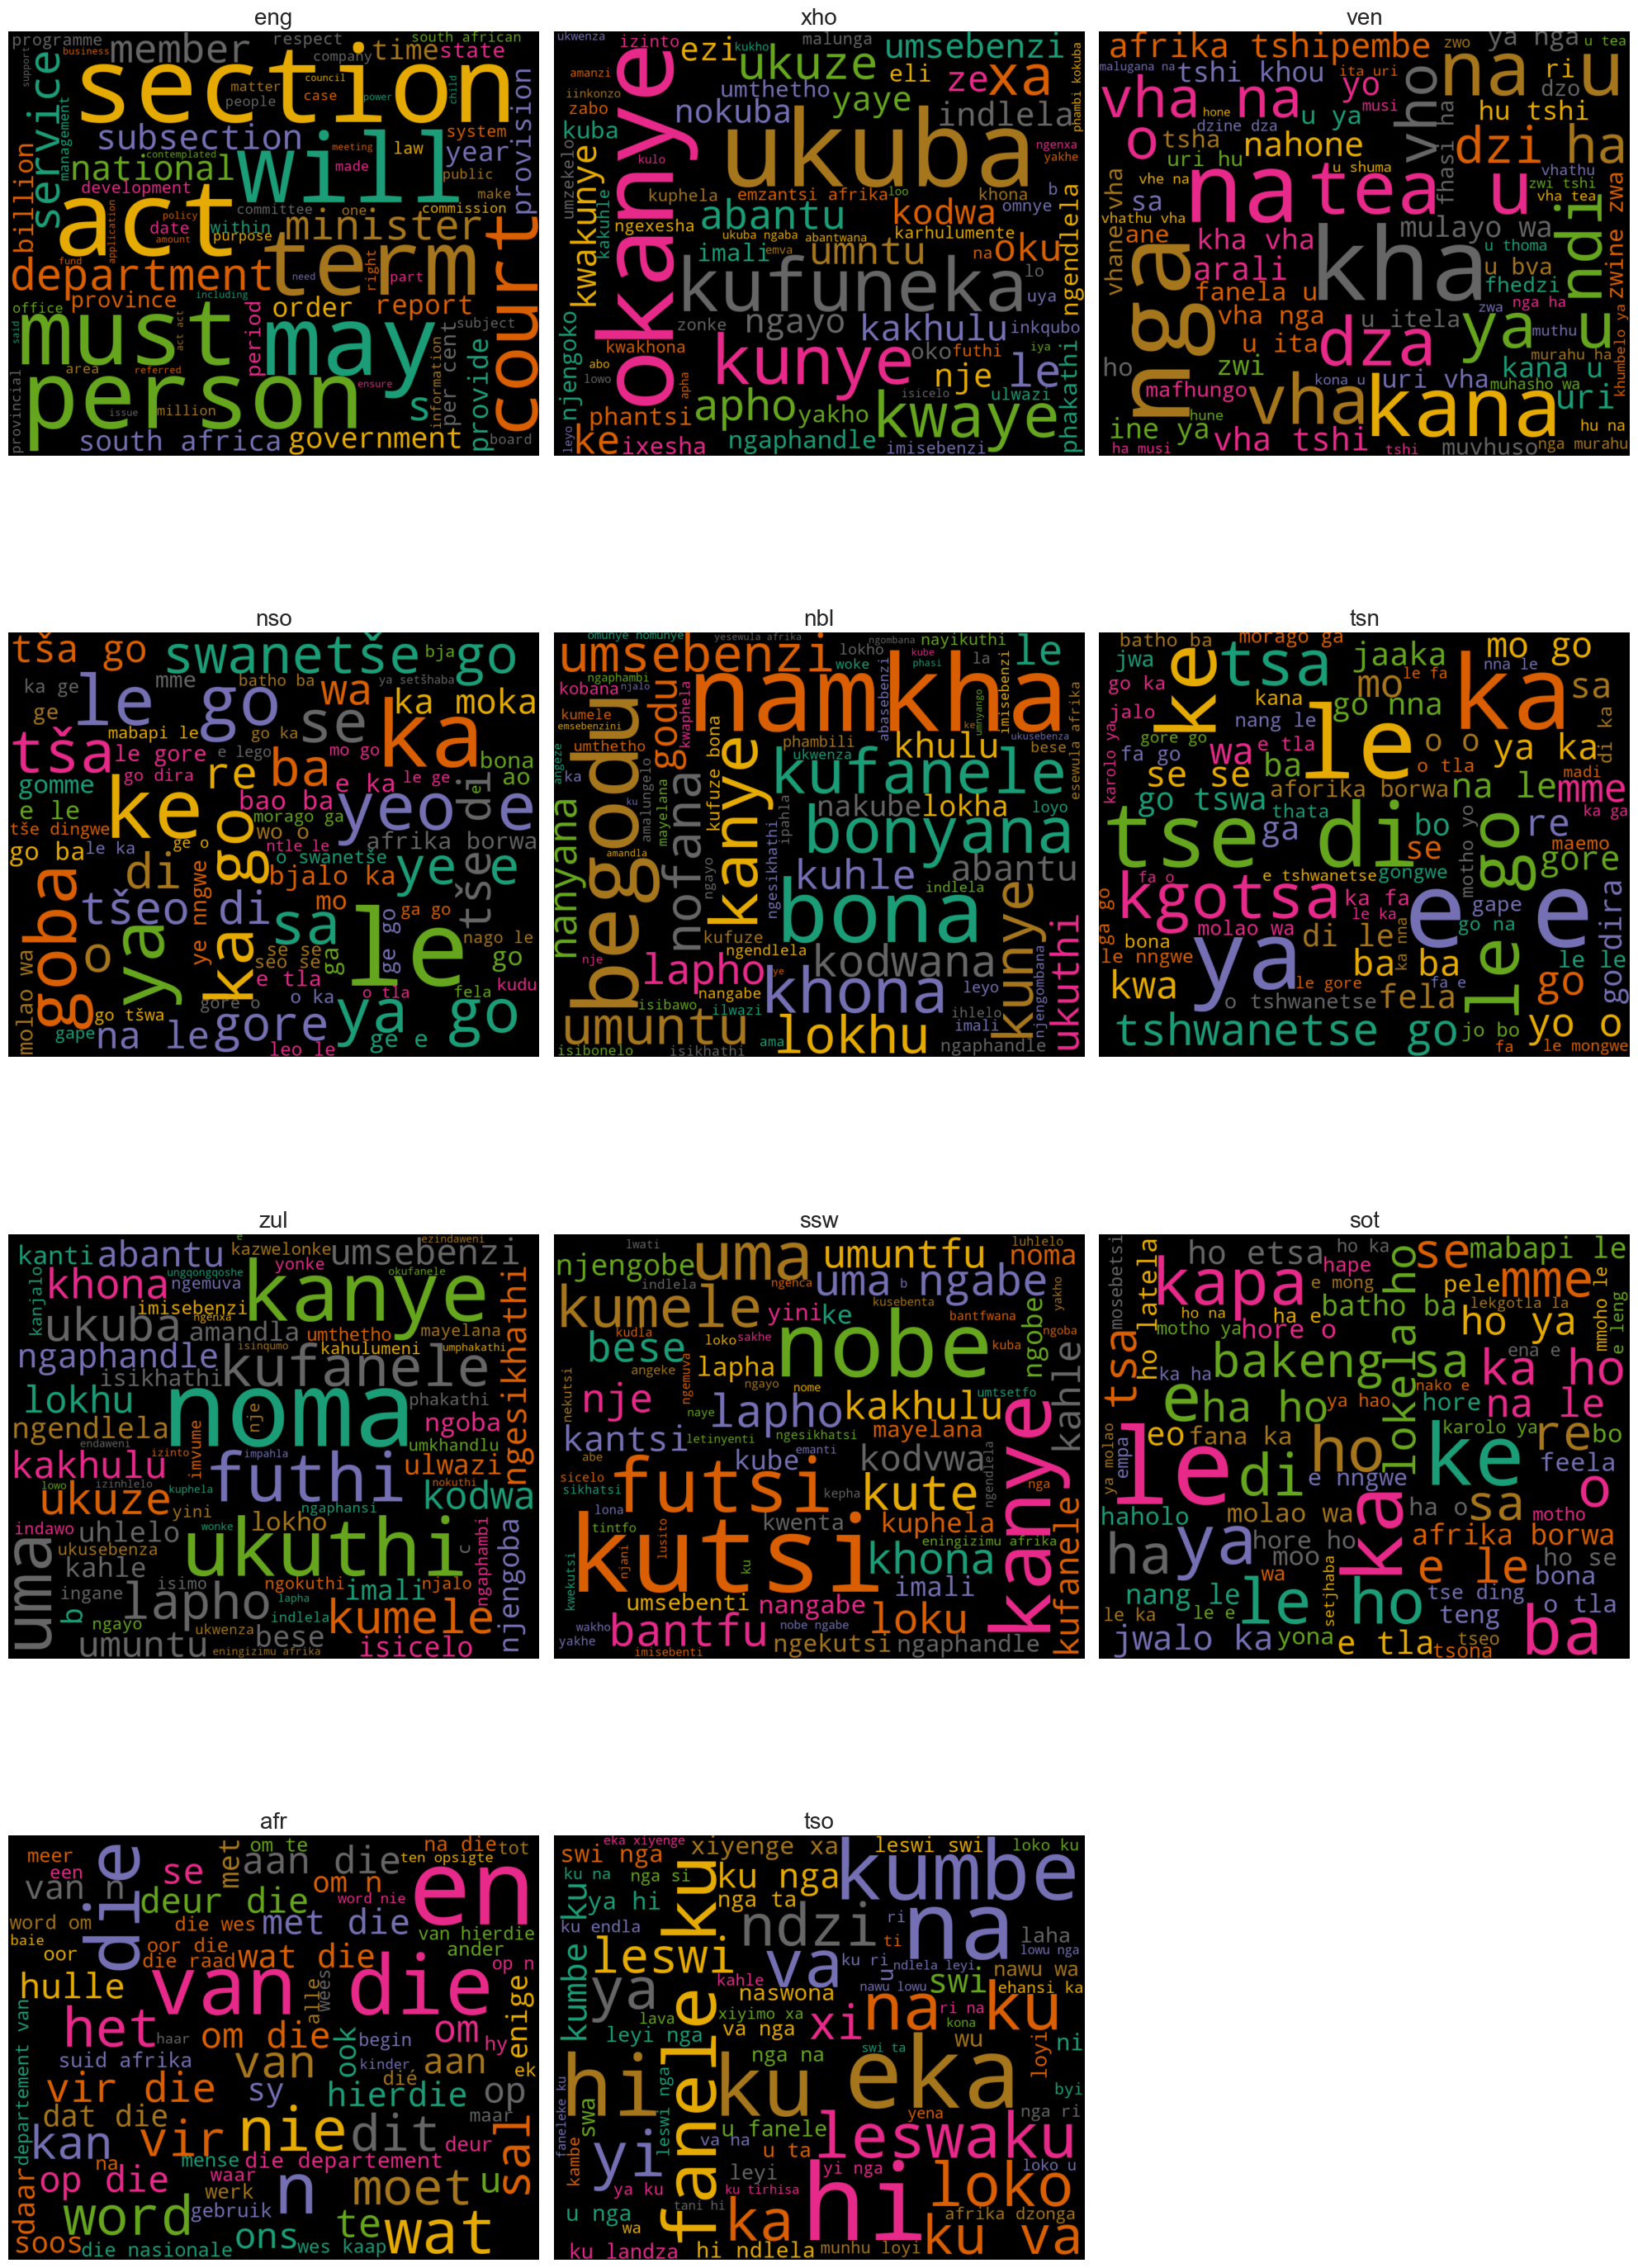

In [24]:
languages = ['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

wc = WordCloud(height=800, width=1000, background_color="black", colormap="Dark2", max_font_size=200, random_state=42, max_words=75)

plt.figure(figsize=(20, 30))

for lang in languages:
    lang_words = ' '.join([text for text in train_df['text'][train_df['lang_id'] == lang]])
    if len(lang_words) > 0:
        wc.generate(lang_words)
        
        plt.subplot(4, 3, languages.index(lang) + 1)
        index = languages.index(lang)
    
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(lang, fontsize=20) 
    
plt.tight_layout()
plt.show()


# Average length of words for each language

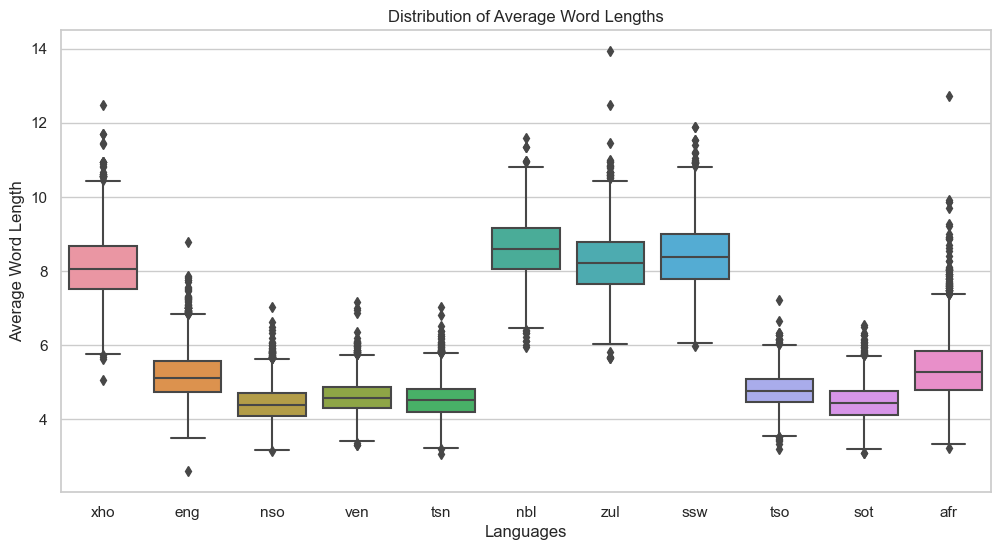

In [25]:
train_df['word_length'] = train_df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]))

plt.figure(figsize=(12, 6))
sns.boxplot(x='lang_id', y='word_length', data=train_df)
plt.title('Distribution of Average Word Lengths')
plt.xlabel('Languages')
plt.ylabel('Average Word Length')
plt.show()


# Data processing

In [29]:
def text_cleaner(text):
    text = text.apply(lambda x: ''.join(i for i in x if i not in punctuation))
    text = text.str.lower()
    return text

In [30]:
train_df.head()

,lang_id,text,word_length
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,8.208333
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,7.161290
2,eng,the province of kwazulu-natal department of tr...,6.162162
3,nso,o netefatša gore o ba file dilo ka moka tše le...,4.450000
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,4.581395


In [31]:
train_df['clean_text'] = text_cleaner(train_df['text'])
test_df['clean_text'] = text_cleaner(test_df['text'])
train_df.head()

,lang_id,text,word_length,clean_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,8.208333,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,7.161290,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulu-natal department of tr...,6.162162,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,4.450000,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,4.581395,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [32]:
test_df.head()

,index,text,clean_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta


In [33]:
list(train_df['text'])


['umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo oluntu lomzantsi afrika',
 'i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga i-dha mayibize uncedo olufanelekileyo elungelweni layo',
 'the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian bridge near tugela ferry the duration of the project will be months',
 'o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela go phela gabotse bjbj',
 'khomishini ya ndinganyiso

# Model building

In [97]:
X=list(train_df['clean_text'])
y=list(train_df['lang_id'])


In [98]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05,random_state =2)

# Model training

## Naive baiyes

In [69]:
vectorizer1 = CountVectorizer()
nb=Pipeline([
    ('vectorizer', vectorizer1),
    ('clf',MultinomialNB(alpha=0.005))
])

In [70]:
nb.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('clf', MultinomialNB(alpha=0.005))])

In [72]:
test_pred= nb.predict(list(test_df['text']))
submission_df = pd.DataFrame({'index': test_df['index'], 'lang_id': test_pred})
submission_df.to_csv('submission4.csv', index=False)

In [ ]:
y_pred_nb=nb.predict(X_test)
print('Model: Support Vector Machine')
print(classification_report(y_test, y_pred_nb))

# Support vector machine

In [73]:
vectorizer2 = CountVectorizer(ngram_range=(1,3),strip_accents='ascii')
svc1 =Pipeline([
    ('vectorizer', vectorizer2),
    ('clf', SVC(kernel='linear',C=10))
])

In [74]:
svc1.fit(X_train,y_train)
y_pred_svc1=svc1.predict(X_test)

In [75]:
print('Model: Logistic Regression')
print(classification_report(y_test, y_pred_svc1))

Model: Logistic Regression
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       150
         eng       1.00      1.00      1.00       145
         nbl       0.99      0.99      0.99       150
         nso       0.99      1.00      1.00       158
         sot       1.00      0.99      1.00       142
         ssw       0.99      1.00      1.00       170
         tsn       1.00      1.00      1.00       155
         tso       1.00      1.00      1.00       143
         ven       1.00      1.00      1.00       139
         xho       0.98      1.00      0.99       154
         zul       0.99      0.98      0.99       144

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650



In [76]:
test_pred3= svc1.predict(test_df['text'])
submission_df = pd.DataFrame({'index': test_df['index'], 'lang_id': test_pred3})
submission_df.to_csv('submission3.csv', index=False)

# Random Forest Classifier

In [99]:
#vectorizer2 = CountVectorizer(ngram_range=(1,3),strip_accents='ascii')
rf1 =Pipeline([
    ('vectorizer', vectorizer2),
    ('clf',  RandomForestClassifier())
])

In [100]:
rf1.fit(X_train,y_train)
y_pred_rf1=rf1.predict(X_test)
print('Model: Random Forest Classifier')
print(classification_report(y_test, y_pred_rf1))

Model: Random Forest Classifier
              precision    recall  f1-score   support

         afr       0.99      1.00      1.00       150
         eng       0.98      1.00      0.99       145
         nbl       0.98      0.94      0.96       150
         nso       0.99      0.98      0.98       158
         sot       0.99      0.99      0.99       142
         ssw       0.98      0.96      0.97       170
         tsn       0.98      0.99      0.98       155
         tso       1.00      1.00      1.00       143
         ven       1.00      1.00      1.00       139
         xho       0.98      1.00      0.99       154
         zul       0.94      0.94      0.94       144

    accuracy                           0.98      1650
   macro avg       0.98      0.98      0.98      1650
weighted avg       0.98      0.98      0.98      1650



In [101]:
test_pred4= rf1.predict(test_df['clean_text'])
submission_df = pd.DataFrame({'index': test_df['index'], 'lang_id': test_pred4})
submission_df.to_csv('submission4.csv', index=False)

# Logistic regression

In [102]:
vectorizer = TfidfVectorizer(ngram_range=(1,4))
lr1 =Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression(C=1000))
])

In [ ]:
lr1.fit(X_train,y_train)
y_pred_lr1=lr1.predict(X_test)

In [ ]:
print('Model: Logistic Regression')
print(classification_report(y_test, y_pred_lr1))

In [ ]:
test_pred= lr1.predict(test_df['clean_text'])
submissin_df = pd.DataFrame({'index': test_df['index'], 'lang_id': test_pred})
submission.to_csv('submission.csv', index=False)
